In [148]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
import tensorflow as tf

## Data Collection

In [103]:
twitter_data = pd.read_csv('dataset/bot_detection_data.csv')

In [104]:
# First 5 rows
twitter_data.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [105]:
# Number of rows and columns
twitter_data.shape

(50000, 11)

In [106]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


Only the Hastags columns has some missing values.

In [107]:
twitter_data.describe(include='all')

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
count,50000.000000,50000,50000,50000.00000,50000.000000,50000.000000,50000,50000.000000,50000,50000,41659
unique,NaN,40566,50000,NaN,NaN,NaN,2,NaN,25199,49989,34247
top,NaN,ksmith,Station activity person against natural majori...,NaN,NaN,NaN,True,NaN,South Michael,2021-02-07 06:50:00,area
freq,NaN,21,1,NaN,NaN,NaN,25004,NaN,44,2,21
mean,548890.680540,NaN,NaN,50.00560,2.513760,4988.602380,NaN,0.500360,NaN,NaN,NaN
std,259756.681425,NaN,NaN,29.18116,1.708563,2878.742898,NaN,0.500005,NaN,NaN,NaN
min,100025.000000,NaN,NaN,0.00000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,323524.250000,NaN,NaN,25.00000,1.000000,2487.750000,NaN,0.000000,NaN,NaN,NaN
50%,548147.000000,NaN,NaN,50.00000,3.000000,4991.500000,NaN,1.000000,NaN,NaN,NaN
75%,772983.000000,NaN,NaN,75.00000,4.000000,7471.000000,NaN,1.000000,NaN,NaN,NaN


**We will be performing the following steps:**
- We will exclude the 'UserID' and 'Location' columns from our analysis. The 'UserID' is a unique identifier that is unlikely to provide useful predictive information. As for 'Location', we are aiming to build a predictive model that is as general as possible, and we don't want the model's predictions to be influenced by location data.
- We will also exclude the 'Username' column, but not before we extract two features from it. The first feature will indicate whether the username contains any numbers, and the second feature will represent the length of the username.
- For the 'Created At' column, we will extract the time of day when each tweet was created. This could provide useful information about whether bots are more active at certain times of day.
- The remaining columns will be processed and prepared for use in a neural network model. This will involve steps such as normalizing numerical data and encoding categorical data.

In [108]:
# Dropping the User ID and Location columns
twitter_data.drop(columns=['User ID', 'Location'], axis=1, inplace=True)

In [109]:
twitter_data.head()

,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Created At,Hashtags
0,flong,Station activity person against natural majori...,85,1,2353,False,1,2020-05-11 15:29:50,NaN
1,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,2022-11-26 05:18:10,both live
2,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,2022-08-08 03:16:54,phone ahead
3,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,2021-08-14 22:27:05,ever quickly new I
4,noah87,Animal sign six data good or.,26,3,8438,False,1,2020-04-13 21:24:21,foreign mention


In [110]:
# Checking numbers in Username
def contains_digits(username):
    return bool(re.search(r'\d', username))

In [111]:
# Creating new column checking for numbers in username
twitter_data['Numbers in Username'] = twitter_data['Username'].apply(contains_digits)

In [112]:
# Creating new column with the username length
twitter_data['Username Length'] = twitter_data['Username'].str.len()

In [113]:
# Checking the new columns
twitter_data.head()

,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Created At,Hashtags,Numbers in Username,Username Length
0,flong,Station activity person against natural majori...,85,1,2353,False,1,2020-05-11 15:29:50,NaN,False,5
1,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,2022-11-26 05:18:10,both live,False,14
2,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,2022-08-08 03:16:54,phone ahead,False,10
3,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,2021-08-14 22:27:05,ever quickly new I,False,6
4,noah87,Animal sign six data good or.,26,3,8438,False,1,2020-04-13 21:24:21,foreign mention,True,6


In [114]:
# Removing the Username column
twitter_data.drop(columns=['Username'], axis=1, inplace=True)

In [115]:
# Getting the time of the day represented as decimal from Created At

# Converting the Created At column from Object to Datetime
twitter_data['Created At'] = pd.to_datetime(twitter_data['Created At'])

# Extract the hour of the day and minute of the hour
hours = twitter_data['Created At'].dt.hour
minutes = twitter_data['Created At'].dt.minute

# Creating new column with decimals representation
twitter_data['Time of Day'] = hours + minutes / 60


In [116]:
# Removing the Created At column
twitter_data.drop(columns=['Created At'], axis=1, inplace=True)

In [117]:
# Reordering the columns
twitter_data = twitter_data[['Numbers in Username', 'Username Length', 'Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Time of Day', 'Hashtags', 'Bot Label']].copy()

In [118]:
twitter_data.head()

,Numbers in Username,Username Length,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Time of Day,Hashtags,Bot Label
0,False,5,Station activity person against natural majori...,85,1,2353,False,15.483333,NaN,1
1,False,14,Authority research natural life material staff...,55,5,9617,True,5.300000,both live,0
2,False,10,Manage whose quickly especially foot none to g...,6,2,4363,True,3.266667,phone ahead,0
3,False,6,Just cover eight opportunity strong policy which.,54,5,2242,True,22.450000,ever quickly new I,1
4,True,6,Animal sign six data good or.,26,3,8438,False,21.400000,foreign mention,1


In [119]:
twitter_data.describe(include='all')

,Numbers in Username,Username Length,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Time of Day,Hashtags,Bot Label
count,50000,50000.000000,50000,50000.00000,50000.000000,50000.000000,50000,50000.000000,41659,50000.000000
unique,2,NaN,50000,NaN,NaN,NaN,2,NaN,34247,NaN
top,False,NaN,Station activity person against natural majori...,NaN,NaN,NaN,True,NaN,area,NaN
freq,37327,NaN,1,NaN,NaN,NaN,25004,NaN,21,NaN
mean,NaN,9.803780,NaN,50.00560,2.513760,4988.602380,NaN,11.993044,NaN,0.500360
std,NaN,2.928646,NaN,29.18116,1.708563,2878.742898,NaN,6.947063,NaN,0.500005
min,NaN,3.000000,NaN,0.00000,0.000000,0.000000,NaN,0.000000,NaN,0.000000
25%,NaN,7.000000,NaN,25.00000,1.000000,2487.750000,NaN,5.966667,NaN,0.000000
50%,NaN,9.000000,NaN,50.00000,3.000000,4991.500000,NaN,12.000000,NaN,1.000000
75%,NaN,12.000000,NaN,75.00000,4.000000,7471.000000,NaN,18.016667,NaN,1.000000


## Exploratory Analysis

In [120]:
# Create a temporary DataFrame for visualization
df_temp = twitter_data.copy()
df_temp['Numbers in Username'] = df_temp['Numbers in Username'].map({True: 'Contains Number', False: 'No Number'})
df_temp['Verified'] = df_temp['Verified'].map({True: 'Verified', False: 'Not Verified'})
df_temp['Bot Label'] = df_temp['Bot Label'].map({1: 'Bot', 0: 'Not Bot'})

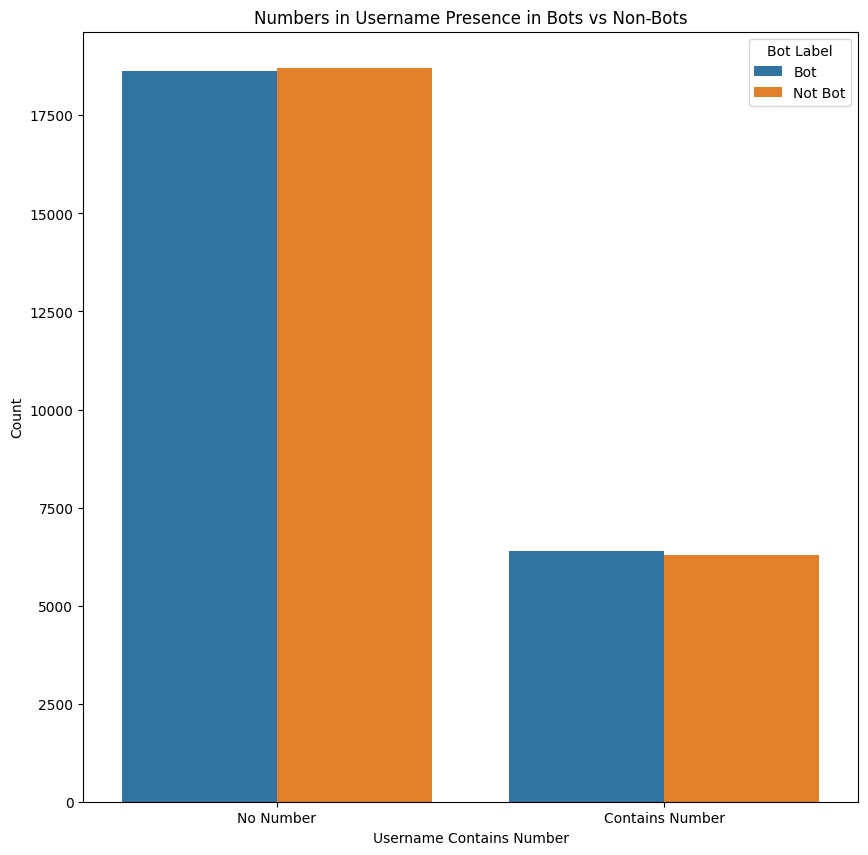

In [121]:
# Checking the distribution of numbers in usernames for bot and non bots
plt.figure(figsize=(10, 10))
sns.countplot(x='Numbers in Username', hue='Bot Label', data=df_temp)
plt.title('Numbers in Username Presence in Bots vs Non-Bots')
plt.xlabel('Username Contains Number')
plt.ylabel('Count')
plt.show()

In the distribution of bot and non-bot accounts in relation to the presence of numbers in their usernames, we observe a roughly equal proportion across both categories. This suggests that the feature 'Numbers in Username' may not significantly differentiate between bot and non-bot accounts. Consequently, we anticipate that this feature may not contribute much to the model.

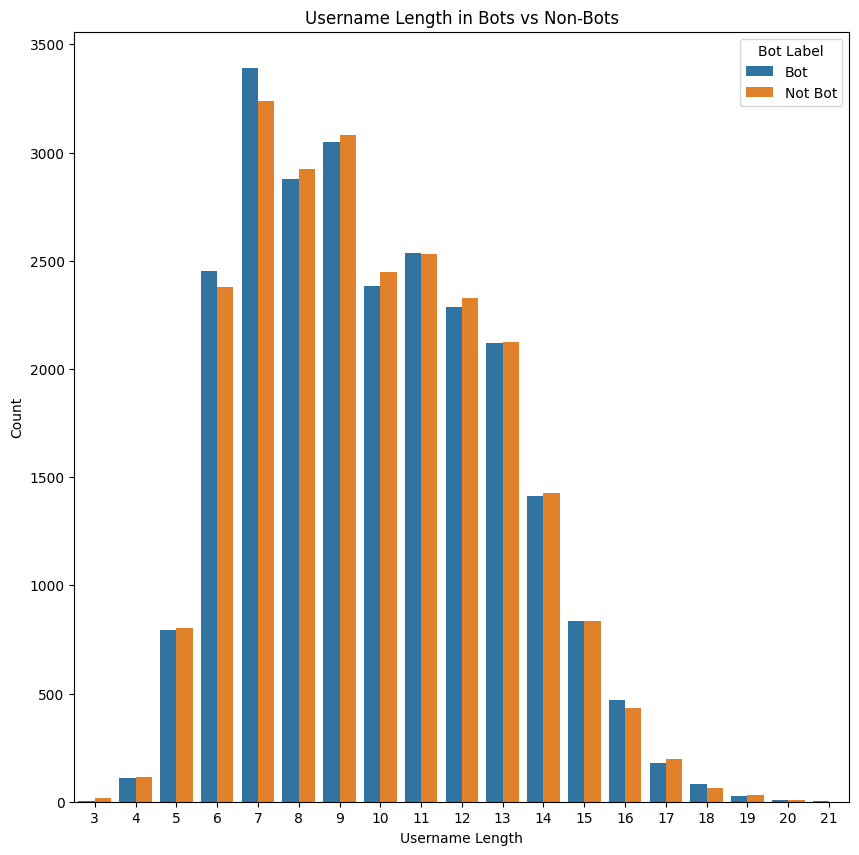

In [122]:
# Count plot for username length
plt.figure(figsize=(10, 10))
sns.countplot(x='Username Length', hue='Bot Label', data=df_temp)
plt.title('Username Length in Bots vs Non-Bots')
plt.xlabel('Username Length')
plt.ylabel('Count')
plt.show()

In the distribution of bot and non-bot accounts in relation to their username lenghts, we observe a roughly equal proportion across both categories. This suggests that the feature 'Username Length' may not significantly differentiate between bot and non-bot accounts. Consequently, we anticipate that this feature may not contribute much to the model.

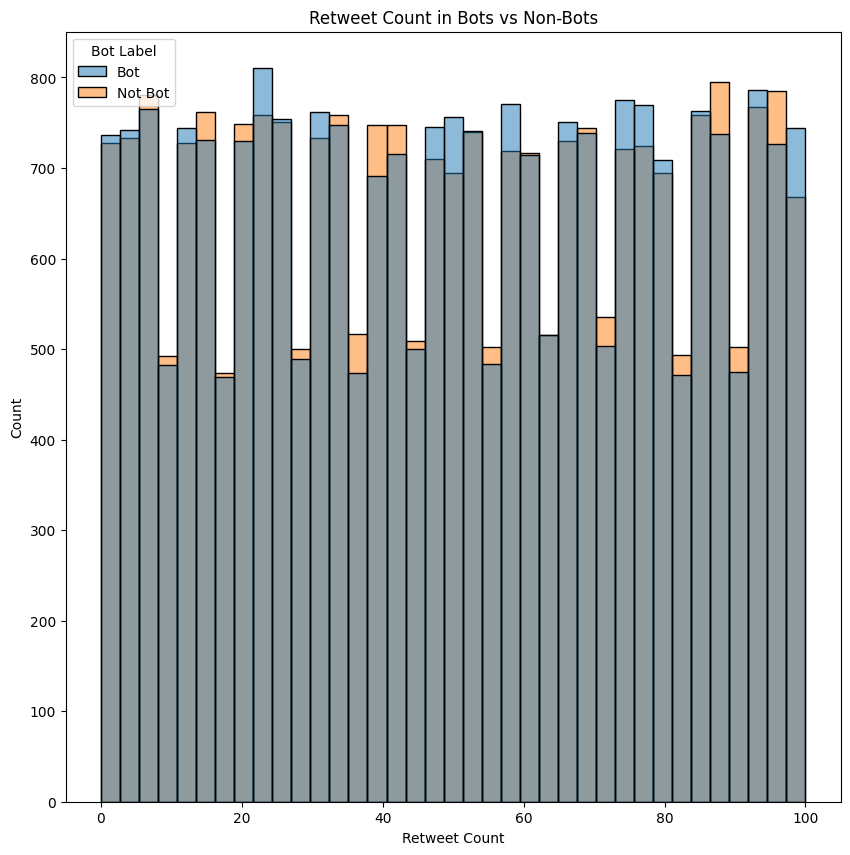

In [123]:
# Hist plot for retweets
plt.figure(figsize=(10, 10))
sns.histplot(x='Retweet Count', hue='Bot Label', data=df_temp)
plt.title('Retweet Count in Bots vs Non-Bots')
plt.xlabel('Retweet Count')
plt.ylabel('Count')
plt.show()

In the distribution of bot and non-bot accounts in relation to their retweet count, we observe a roughly equal proportion across both categories. This suggests that the feature 'Retweet Count' may not significantly differentiate between bot and non-bot accounts. Consequently, we anticipate that this feature may not contribute much to the model.

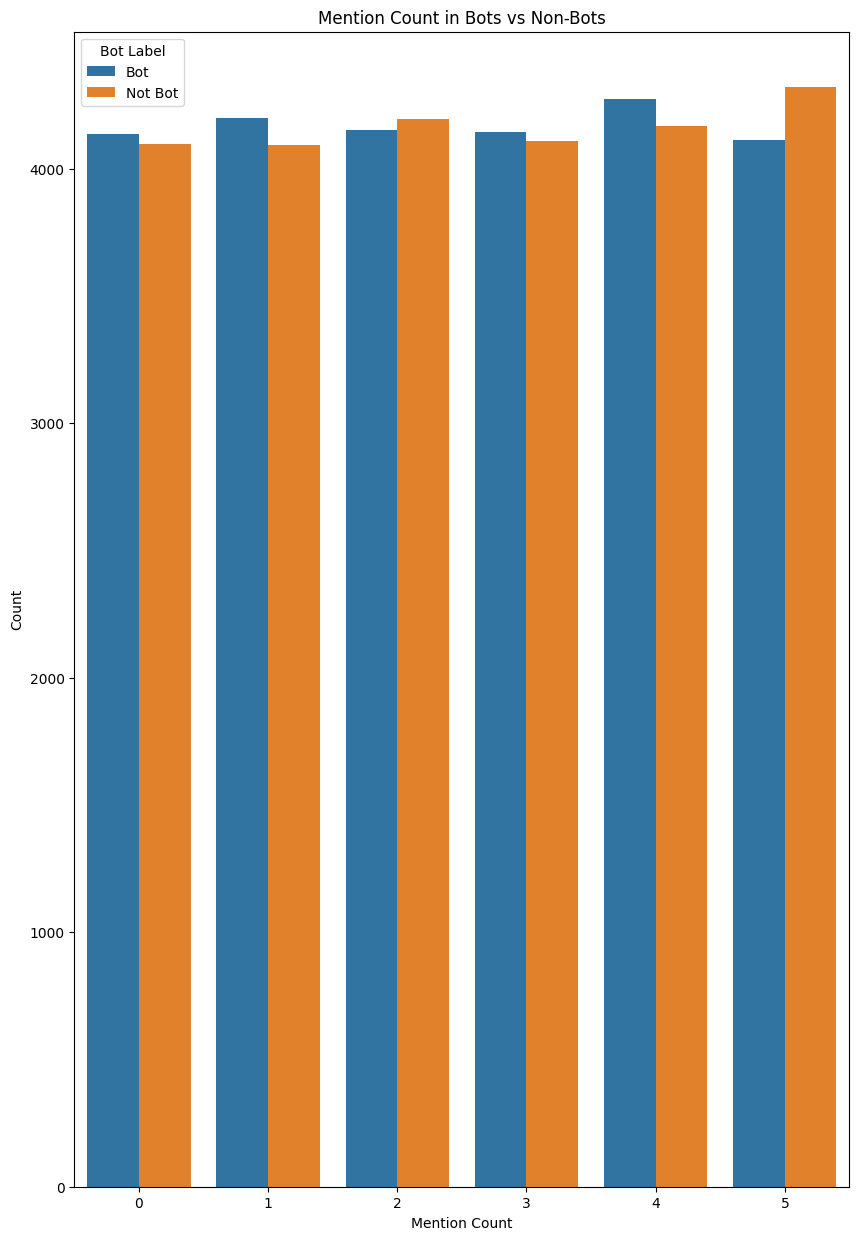

In [124]:
# Count plot for mentions
plt.figure(figsize=(10, 15))
sns.countplot(x='Mention Count', hue='Bot Label', data=df_temp)
plt.title('Mention Count in Bots vs Non-Bots')
plt.xlabel('Mention Count')
plt.ylabel('Count')
plt.show()

Again, in the distribution of bot and non-bot accounts in relation to their mention count, we observe a roughly equal proportion across both categories. This suggests that the feature 'Mention Count' may not significantly differentiate between bot and non-bot accounts. For 5 mentions seems like there is a slightly higher not bot proportion.

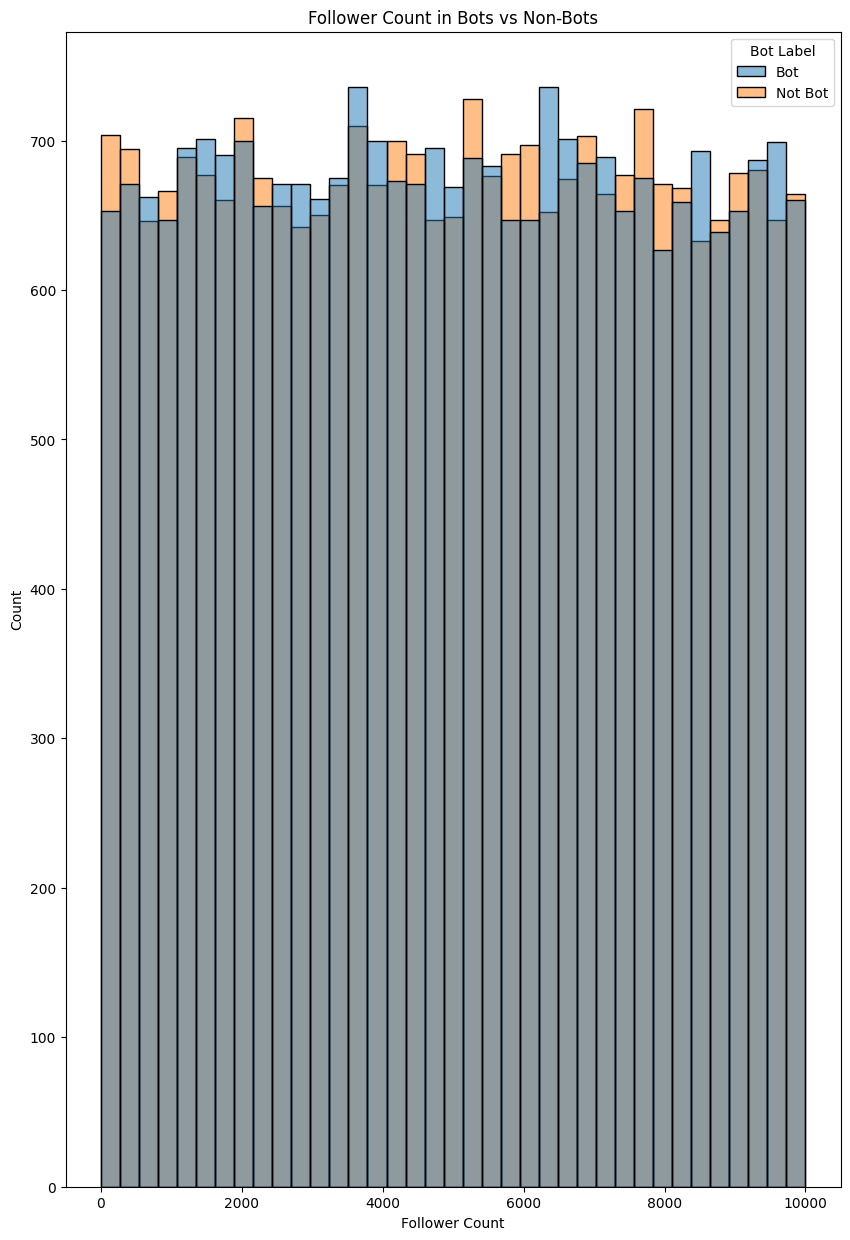

In [125]:
# Count plot for mentions
plt.figure(figsize=(10, 15))
sns.histplot(x='Follower Count', hue='Bot Label', data=df_temp)
plt.title('Follower Count in Bots vs Non-Bots')
plt.xlabel('Follower Count')
plt.ylabel('Count')
plt.show()

Again, in the distribution of bot and non-bot accounts in relation to their follower count, we observe a roughly equal proportion across both categories. This suggests that the feature 'Follower Count' may not significantly differentiate between bot and non-bot accounts.

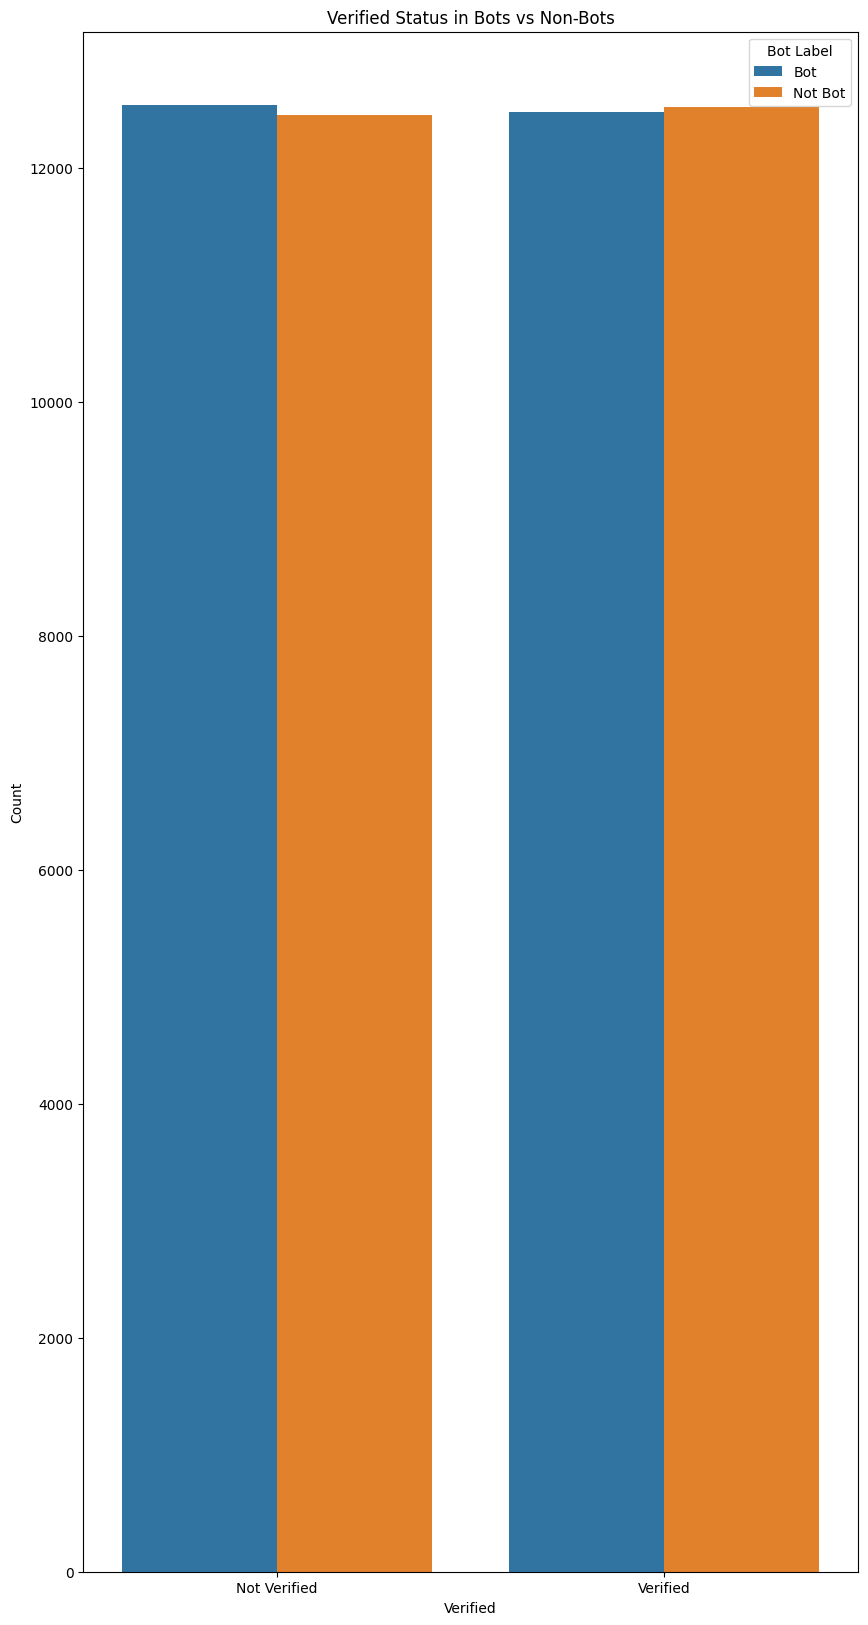

In [126]:
# Checking the distribution virified status for bot and non bots
plt.figure(figsize=(10, 20))
sns.countplot(x='Verified', hue='Bot Label', data=df_temp)
plt.title('Verified Status in Bots vs Non-Bots')
plt.xlabel('Verified')
plt.ylabel('Count')
plt.show()

There seems to be a slightly higher proportion of non bots in verified accounts and a slightly higher proportion of bots in non verified accounts.

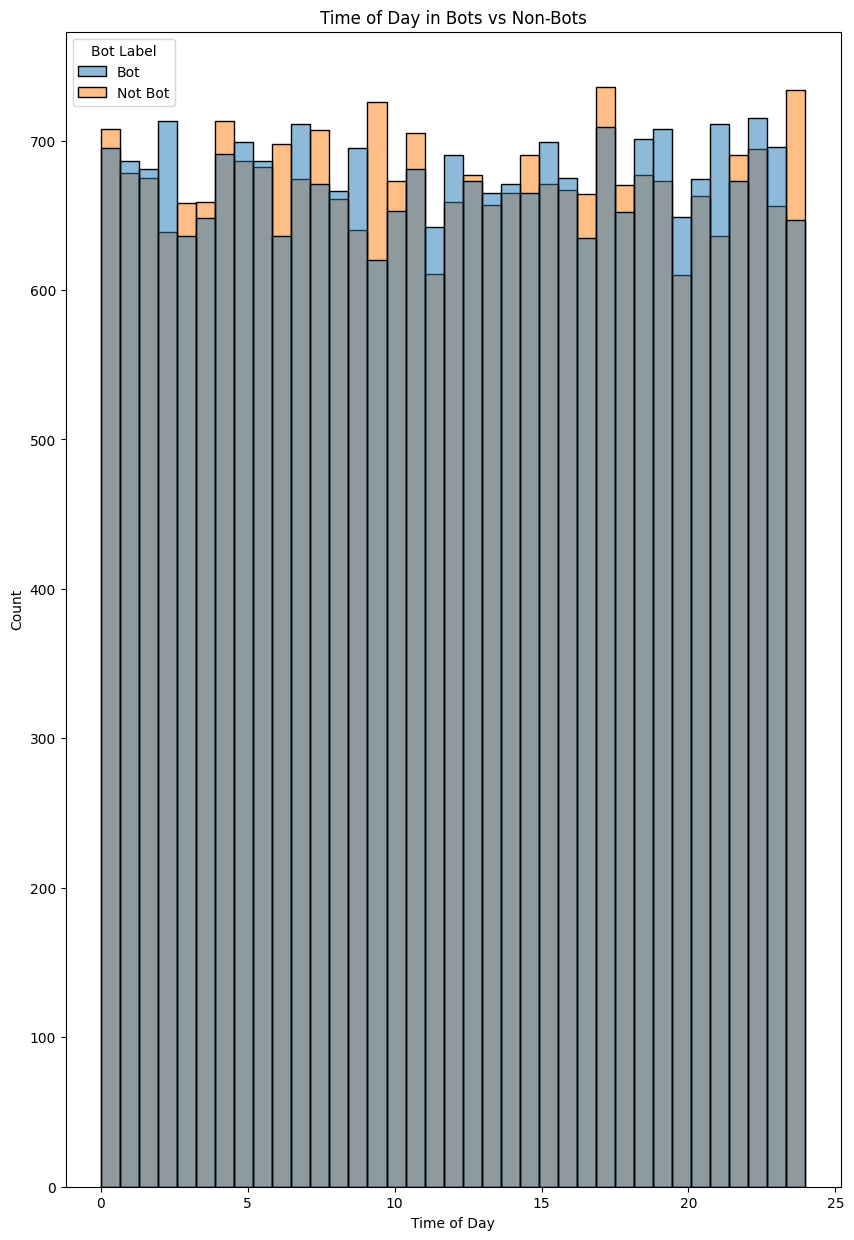

In [127]:
# Hist plot for time of day
plt.figure(figsize=(10, 15))
sns.histplot(x='Time of Day', hue='Bot Label', data=df_temp)
plt.title('Time of Day in Bots vs Non-Bots')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.show()

There seems to be a higher activity of non bot users near 10:00 and at some point before 00:00. No clear patterns in the plot. 

## Correlation Matrix

In [128]:
# Getting the numeric columns
twitter_data_numeric = twitter_data.select_dtypes(include="number").copy()
twitter_data_numeric.head()

,Username Length,Retweet Count,Mention Count,Follower Count,Time of Day,Bot Label
0,5,85,1,2353,15.483333,1
1,14,55,5,9617,5.300000,0
2,10,6,2,4363,3.266667,0
3,6,54,5,2242,22.450000,1
4,6,26,3,8438,21.400000,1


In [129]:
# Removing the bot label, because that should be treated as boolean
twitter_data_numeric.drop(columns='Bot Label', axis=1, inplace=True)
twitter_data_numeric.head()

,Username Length,Retweet Count,Mention Count,Follower Count,Time of Day
0,5,85,1,2353,15.483333
1,14,55,5,9617,5.300000
2,10,6,2,4363,3.266667
3,6,54,5,2242,22.450000
4,6,26,3,8438,21.400000


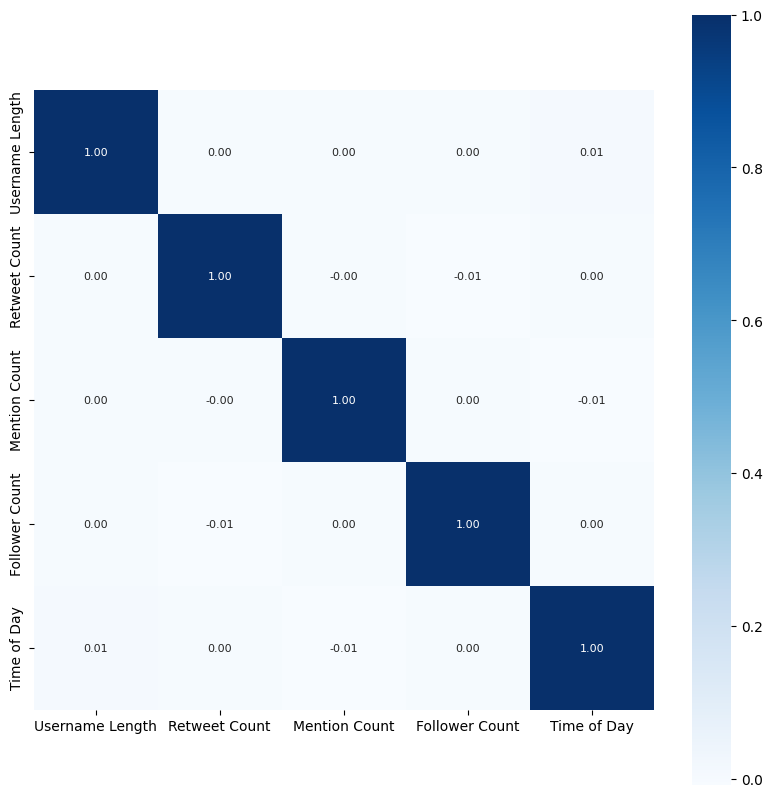

In [130]:
# Constructing heat map
correlation = twitter_data_numeric.corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size': 8}, cmap='Blues' )
plt.show()

There doesn't seem to be correlations.

## Distribution of the Target Variable

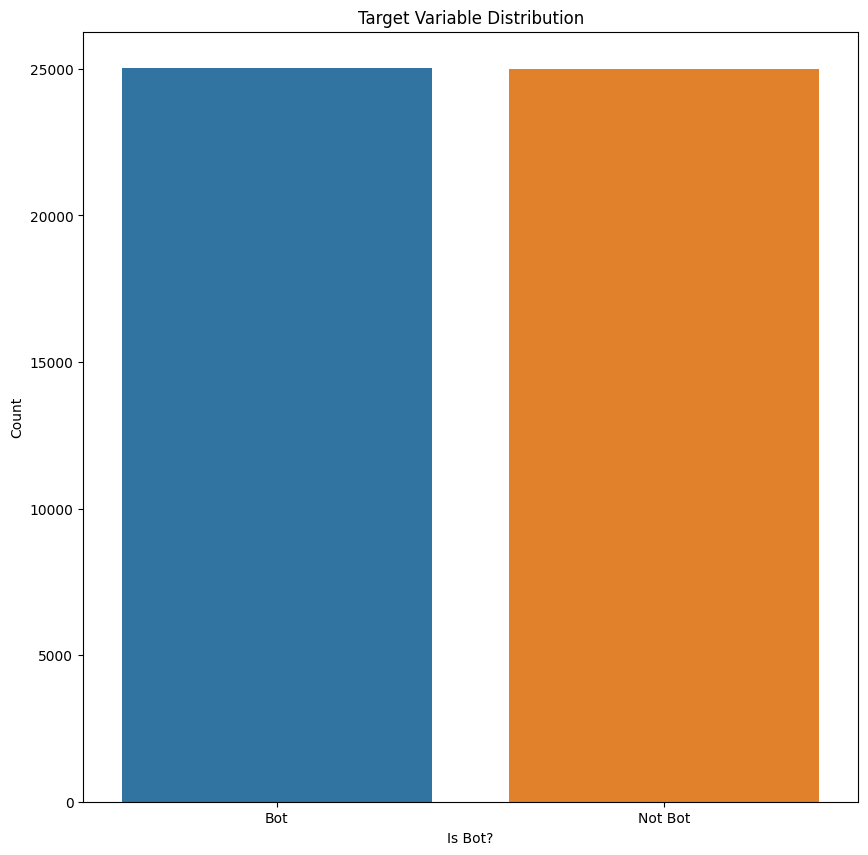

In [131]:
plt.figure(figsize=(10, 10))
sns.countplot(data=df_temp, x='Bot Label')
plt.title('Target Variable Distribution')
plt.xlabel('Is Bot?')
plt.ylabel('Count')
plt.show()

The porportions of bot and not bot accounts are very similar, so there shouldn't be any problems with the model due to imbalanced classes. 

## General Insights
 - There aren't any clear patters that would allow us to get an insight regarding which features will be more important for the model.
 - The distribution of bot and not bot accounts is pretty even, so there shouldn't be any problems due to imbalanced classes.

## Data Pre-Processing

In [132]:
# Checking the types of the current dataframe
twitter_data.dtypes

Numbers in Username       bool
Username Length          int64
Tweet                   object
Retweet Count            int64
Mention Count            int64
Follower Count           int64
Verified                  bool
Time of Day            float64
Hashtags                object
Bot Label                int64
dtype: object

In [133]:
# Making a new copy of the dataframe to process
twitter_data_processed = twitter_data.copy()

In [134]:
# Turning the bool columns into int
twitter_data_processed['Numbers in Username'] = twitter_data_processed['Numbers in Username'].astype(int)
twitter_data_processed['Verified'] = twitter_data_processed['Verified'].astype(int)

In [135]:
# Filling the nan values in Hashtags
twitter_data_processed['Hashtags'] = twitter_data_processed['Hashtags'].fillna('')

In [136]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ['Username Length', 'Retweet Count', 'Mention Count', 'Follower Count', 'Time of Day']),
    (FunctionTransformer(lambda x: TfidfVectorizer(min_df=1, stop_words='english', lowercase=True).fit_transform(x).toarray()), 'Tweet'),
    (FunctionTransformer(lambda x: TfidfVectorizer(min_df=1, stop_words='english', lowercase=True).fit_transform(x).toarray()), 'Hashtags')
)

# Creating X and Y
X = twitter_data_processed.drop('Bot Label', axis=1)
Y = twitter_data_processed['Bot Label']

# Build train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Fit the column transformer to train data
ct.fit(X_train)

# Transform train and test data with normalization (MinMaxScaler), OneHotEncoder and TfidfVectorizer
X_train_transformed = ct.transform(X_train)
X_test_transformed = ct.transform(X_test)

In [137]:
# Checking the shapes
X_train_transformed.shape, X_test_transformed.shape, Y_train.shape, Y_test.shape 

((35000, 1531), (15000, 1531), (35000,), (15000,))

**Due the the TF-IDF vectorizer we are getting 1531 features which could bring some issues. We will be trying to build a model first and if there are any issues, we will be using some dimensionality reduction technique.**

## Neural Network

In [138]:
tf.random.set_seed(42)

# Create the model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_1 = model_1.fit(X_train_transformed,
                    Y_train,
                    epochs=100,
                    validation_data=(X_test_transformed, Y_test))


Epoch 1/100
1094/1094 [==============================] - 4s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4988 - precision_15: 0.4992 - recall_15: 0.5152 - val_loss: 0.6932 - val_binary_accuracy: 0.4993 - val_precision_15: 0.4998 - val_recall_15: 0.9912
Epoch 2/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6922 - binary_accuracy: 0.5135 - precision_15: 0.5107 - recall_15: 0.6602 - val_loss: 0.6934 - val_binary_accuracy: 0.5030 - val_precision_15: 0.5026 - val_recall_15: 0.6388
Epoch 3/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6863 - binary_accuracy: 0.5423 - precision_15: 0.5369 - recall_15: 0.6205 - val_loss: 0.6970 - val_binary_accuracy: 0.5053 - val_precision_15: 0.5049 - val_recall_15: 0.5784
Epoch 4/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6769 - binary_accuracy: 0.5620 - precision_15: 0.5585 - recall_15: 0.5949 - val_loss: 0.7014 - val_binary_accuracy: 0.5005 - val_precision_15: 0.5008 - val_recall

1094/1094 [==============================] - 2s 2ms/step - loss: 0.5551 - binary_accuracy: 0.7074 - precision_15: 0.6951 - recall_15: 0.7398 - val_loss: 0.9144 - val_binary_accuracy: 0.4901 - val_precision_15: 0.4910 - val_recall_15: 0.5210
Epoch 34/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5537 - binary_accuracy: 0.7080 - precision_15: 0.6966 - recall_15: 0.7379 - val_loss: 0.9324 - val_binary_accuracy: 0.4913 - val_precision_15: 0.4921 - val_recall_15: 0.5247
Epoch 35/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5510 - binary_accuracy: 0.7094 - precision_15: 0.6988 - recall_15: 0.7369 - val_loss: 0.9434 - val_binary_accuracy: 0.4936 - val_precision_15: 0.4944 - val_recall_15: 0.5363
Epoch 36/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5496 - binary_accuracy: 0.7095 - precision_15: 0.6984 - recall_15: 0.7382 - val_loss: 0.9522 - val_binary_accuracy: 0.4905 - val_precision_15: 0.4916 - val_recall_15: 0.53

1094/1094 [==============================] - 2s 2ms/step - loss: 0.5099 - binary_accuracy: 0.7303 - precision_15: 0.7216 - recall_15: 0.7505 - val_loss: 1.1895 - val_binary_accuracy: 0.4919 - val_precision_15: 0.4926 - val_recall_15: 0.5202
Epoch 66/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5091 - binary_accuracy: 0.7298 - precision_15: 0.7205 - recall_15: 0.7516 - val_loss: 1.2103 - val_binary_accuracy: 0.4901 - val_precision_15: 0.4909 - val_recall_15: 0.5149
Epoch 67/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5075 - binary_accuracy: 0.7310 - precision_15: 0.7229 - recall_15: 0.7497 - val_loss: 1.2294 - val_binary_accuracy: 0.4933 - val_precision_15: 0.4941 - val_recall_15: 0.5286
Epoch 68/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5066 - binary_accuracy: 0.7307 - precision_15: 0.7215 - recall_15: 0.7519 - val_loss: 1.2087 - val_binary_accuracy: 0.4918 - val_precision_15: 0.4925 - val_recall_15: 0.51

1094/1094 [==============================] - 2s 2ms/step - loss: 0.4855 - binary_accuracy: 0.7375 - precision_15: 0.7293 - recall_15: 0.7560 - val_loss: 1.5607 - val_binary_accuracy: 0.4942 - val_precision_15: 0.4949 - val_recall_15: 0.5262
Epoch 98/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4844 - binary_accuracy: 0.7367 - precision_15: 0.7271 - recall_15: 0.7586 - val_loss: 1.5957 - val_binary_accuracy: 0.4941 - val_precision_15: 0.4947 - val_recall_15: 0.5186
Epoch 99/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4853 - binary_accuracy: 0.7372 - precision_15: 0.7287 - recall_15: 0.7562 - val_loss: 1.5653 - val_binary_accuracy: 0.4931 - val_precision_15: 0.4935 - val_recall_15: 0.5033
Epoch 100/100
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4840 - binary_accuracy: 0.7385 - precision_15: 0.7304 - recall_15: 0.7569 - val_loss: 1.6210 - val_binary_accuracy: 0.4924 - val_precision_15: 0.4931 - val_recall_15: 0.5

<Axes: title={'center': 'Model_1'}>

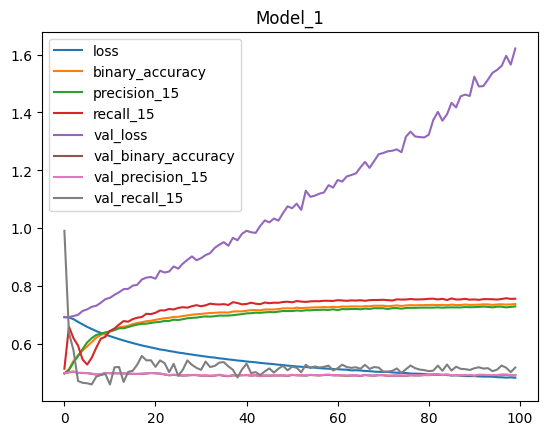

In [139]:
# Plot normalized data loss curves
pd.DataFrame(history_1.history).plot(title='Model_1')

The accuracy on the train set is 0.66 and in the test set is 0.50, which means there is overfitting. 

## Lowering the epochs

In [140]:
tf.random.set_seed(42)

# Create the model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_2 = model_2.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4979 - precision_16: 0.4982 - recall_16: 0.4596 - val_loss: 0.6932 - val_binary_accuracy: 0.5003 - val_precision_16: 0.5003 - val_recall_16: 1.0000
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6916 - binary_accuracy: 0.5209 - precision_16: 0.5182 - recall_16: 0.6049 - val_loss: 0.6941 - val_binary_accuracy: 0.5057 - val_precision_16: 0.5048 - val_recall_16: 0.6326
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6835 - binary_accuracy: 0.5569 - precision_16: 0.5603 - recall_16: 0.5315 - val_loss: 0.6985 - val_binary_accuracy: 0.4979 - val_precision_16: 0.4979 - val_recall_16: 0.4203
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6695 - binary_accuracy: 0.5880 - precision_16: 0.5920 - recall_16: 0.5680 - val_loss: 0.7085 - val_binary_accuracy: 0.4996 - val_precision_16: 0.4999 - val_recall_16:

**The accuracy on train and test data are similar to what was obtained with 100 epochs, so we will be keeping the 20 epochs, but the model is still overfitting**

## Changing the amount of layers

In [141]:
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_3 = model_3.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6933 - binary_accuracy: 0.5034 - precision_17: 0.5036 - recall_17: 0.5249 - val_loss: 0.6932 - val_binary_accuracy: 0.4993 - val_precision_17: 0.4998 - val_recall_17: 0.9512
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6905 - binary_accuracy: 0.5353 - precision_17: 0.5345 - recall_17: 0.5526 - val_loss: 0.6937 - val_binary_accuracy: 0.5041 - val_precision_17: 0.5036 - val_recall_17: 0.6088
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6836 - binary_accuracy: 0.5681 - precision_17: 0.5637 - recall_17: 0.6058 - val_loss: 0.6979 - val_binary_accuracy: 0.5011 - val_precision_17: 0.5013 - val_recall_17: 0.5532
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6748 - binary_accuracy: 0.5859 - precision_17: 0.5768 - recall_17: 0.6476 - val_loss: 0.7015 - val_binary_accuracy: 0.4989 - val_precision_17: 0.4994 - val_recall_17:

In [142]:
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_4 = model_4.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4981 - precision_18: 0.4987 - recall_18: 0.5795 - val_loss: 0.6932 - val_binary_accuracy: 0.5005 - val_precision_18: 0.5004 - val_recall_18: 0.9999
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6929 - binary_accuracy: 0.5082 - precision_18: 0.5066 - recall_18: 0.6609 - val_loss: 0.6931 - val_binary_accuracy: 0.5055 - val_precision_18: 0.5037 - val_recall_18: 0.7808
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6894 - binary_accuracy: 0.5371 - precision_18: 0.5318 - recall_18: 0.6258 - val_loss: 0.6955 - val_binary_accuracy: 0.5043 - val_precision_18: 0.5038 - val_recall_18: 0.6119
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6811 - binary_accuracy: 0.5655 - precision_18: 0.5529 - recall_18: 0.6884 - val_loss: 0.6998 - val_binary_accuracy: 0.5062 - val_precision_18: 0.5043 - val_recall_18:

## Changing the neurons per layer

In [143]:
tf.random.set_seed(42)

# Create the model
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_5 = model_5.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6933 - binary_accuracy: 0.4978 - precision_19: 0.4984 - recall_19: 0.5832 - val_loss: 0.6933 - val_binary_accuracy: 0.4989 - val_precision_19: 0.4996 - val_recall_19: 0.9833
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6897 - binary_accuracy: 0.5329 - precision_19: 0.5307 - recall_19: 0.5744 - val_loss: 0.6952 - val_binary_accuracy: 0.4955 - val_precision_19: 0.4971 - val_recall_19: 0.7198
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6717 - binary_accuracy: 0.5847 - precision_19: 0.5782 - recall_19: 0.6284 - val_loss: 0.7086 - val_binary_accuracy: 0.5027 - val_precision_19: 0.5026 - val_recall_19: 0.5863
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6415 - binary_accuracy: 0.6254 - precision_19: 0.6159 - recall_19: 0.6680 - val_loss: 0.7258 - val_binary_accuracy: 0.5025 - val_precision_19: 0.5024 - val_recall_19:

In [144]:
tf.random.set_seed(42)

# Create the model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(2, activation="relu"),
  tf.keras.layers.Dense(2, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_6 = model_6.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4969 - precision_20: 0.4972 - recall_20: 0.4947 - val_loss: 0.6932 - val_binary_accuracy: 0.5003 - val_precision_20: 0.5003 - val_recall_20: 0.9949
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6926 - binary_accuracy: 0.5131 - precision_20: 0.5110 - recall_20: 0.6236 - val_loss: 0.6933 - val_binary_accuracy: 0.5003 - val_precision_20: 0.5004 - val_recall_20: 0.7626
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6891 - binary_accuracy: 0.5378 - precision_20: 0.5347 - recall_20: 0.5889 - val_loss: 0.6953 - val_binary_accuracy: 0.5002 - val_precision_20: 0.5005 - val_recall_20: 0.5853
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6836 - binary_accuracy: 0.5571 - precision_20: 0.5497 - recall_20: 0.6350 - val_loss: 0.6987 - val_binary_accuracy: 0.5004 - val_precision_20: 0.5006 - val_recall_20:

## Changing Optimizer

In [145]:
tf.random.set_seed(42)

# Create the model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.SGD(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_7 = model_7.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 4s 2ms/step - loss: 0.6931 - binary_accuracy: 0.5018 - precision_21: 0.5027 - recall_21: 0.4022 - val_loss: 0.6932 - val_binary_accuracy: 0.5009 - val_precision_21: 0.5007 - val_recall_21: 0.8248
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6931 - binary_accuracy: 0.5063 - precision_21: 0.5055 - recall_21: 0.6167 - val_loss: 0.6932 - val_binary_accuracy: 0.4991 - val_precision_21: 0.4996 - val_recall_21: 0.6316
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6931 - binary_accuracy: 0.5066 - precision_21: 0.5061 - recall_21: 0.5784 - val_loss: 0.6932 - val_binary_accuracy: 0.4982 - val_precision_21: 0.4982 - val_recall_21: 0.4116
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6930 - binary_accuracy: 0.5060 - precision_21: 0.5064 - recall_21: 0.5034 - val_loss: 0.6932 - val_binary_accuracy: 0.4966 - val_precision_21: 0.4976 - val_recall_21:

In [146]:
tf.random.set_seed(42)

# Create the model
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.SGD(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_8 = model_8.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4993 - precision_22: 0.4996 - recall_22: 0.3952 - val_loss: 0.6931 - val_binary_accuracy: 0.5029 - val_precision_22: 0.5018 - val_recall_22: 0.8985
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6931 - binary_accuracy: 0.5033 - precision_22: 0.5031 - recall_22: 0.5955 - val_loss: 0.6931 - val_binary_accuracy: 0.5025 - val_precision_22: 0.5020 - val_recall_22: 0.7005
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6931 - binary_accuracy: 0.5065 - precision_22: 0.5056 - recall_22: 0.6138 - val_loss: 0.6932 - val_binary_accuracy: 0.5003 - val_precision_22: 0.5009 - val_recall_22: 0.3432
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6930 - binary_accuracy: 0.5054 - precision_22: 0.5053 - recall_22: 0.5427 - val_loss: 0.6931 - val_binary_accuracy: 0.5011 - val_precision_22: 0.5012 - val_recall_22:

## Changing activation function

In [147]:
tf.random.set_seed(42)

# Create the model
model_9 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="sigmoid"),
  tf.keras.layers.Dense(4, activation="sigmoid"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_9.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Train the model
history_9 = model_9.fit(X_train_transformed,
                    Y_train,
                    epochs=20,
                    validation_data=(X_test_transformed, Y_test))

Epoch 1/20
1094/1094 [==============================] - 4s 2ms/step - loss: 0.6934 - binary_accuracy: 0.5011 - precision_23: 0.5018 - recall_23: 0.4039 - val_loss: 0.6932 - val_binary_accuracy: 0.5003 - val_precision_23: 0.5003 - val_recall_23: 1.0000
Epoch 2/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6930 - binary_accuracy: 0.5067 - precision_23: 0.5069 - recall_23: 0.5254 - val_loss: 0.6932 - val_binary_accuracy: 0.4991 - val_precision_23: 0.4997 - val_recall_23: 0.9316
Epoch 3/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6925 - binary_accuracy: 0.5182 - precision_23: 0.5205 - recall_23: 0.4707 - val_loss: 0.6932 - val_binary_accuracy: 0.4980 - val_precision_23: 0.4874 - val_recall_23: 0.0642
Epoch 4/20
1094/1094 [==============================] - 2s 2ms/step - loss: 0.6917 - binary_accuracy: 0.5365 - precision_23: 0.5385 - recall_23: 0.5152 - val_loss: 0.6932 - val_binary_accuracy: 0.5008 - val_precision_23: 0.5013 - val_recall_23:

## Conclusions

 - The dataset seems to be artificially generated. As it seems strange that no matter what is done, the val_binary_accuracy seems to always be around 0.5 (accuracy in the test set).
 - The accuracy in the train set can be increased by increasing the number of layers and/or the number of neurons per layer, but since the test accuracy tends to remain always the same, this is just interpreted as overfitting.
 - The charts in the exploratory analysis is also strange since, pretty much every feature has a 50-50% of bot and non bot accounts.
 - Finally as an extra check the Code Interpreter feature from ChatGPT was used. I asked about the Usernames and Location columns and this was the response:
 
*The Username and Location fields in this dataset show some patterns that could suggest the data is artificially generated, or at least not a typical sample of real-world Twitter data:
Usernames: The most common usernames in the dataset are variations of the surname "Smith" (e.g., "ksmith", "usmith", "msmith", "ismith"), each appearing between 13 and 21 times. In a real-world scenario, Twitter usernames must be unique, so it's unusual to see the same username multiple times in the dataset. This could indicate that the usernames were generated according to some rule or pattern, rather than being actual Twitter usernames.  
Locations: The most common locations (e.g., "South Michael", "Lake Michael", "North Jennifer", "North Michael", "Lake David") seem to follow a pattern of a direction or geographic feature followed by a common first name. This is not typical for how users usually specify their locations on Twitter. In general, users tend to list either a city, state, country, or a more general geographic area (e.g., "New York", "California", "USA", "The World"). The pattern seen in the data suggests that the locations might have been artificially generated.  
These patterns don't conclusively prove that the data is artificial, but they do suggest that the data might not be a typical sample of real-world Twitter data. It's also possible that the data was intentionally anonymized or modified for privacy reasons or to create a balanced dataset for research or model training purposes.*

This will conclude this project as a firt exercise to process the data, creation of the neural network and testing of different configurations. 